We will work on Apple stock prices data set from 2012 into 21 -10 - 2020 . Our goal to predict stock price in future. 


In [ ]:
#Import Libraries 
import numpy as np
import pandas as pd
import os, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pandas_datareader as pdr
df = pdr.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-10-21')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#See first 5 rows
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.691425
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.759631
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.901293
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.036158
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,13.015480


In [ ]:
# See n of observations an features
df.shape

(2216, 6)

In [ ]:
# Convert the date index into a datetime 
df.index = pd.to_datetime(df.index, format="%Y/%m/%d")

In [ ]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

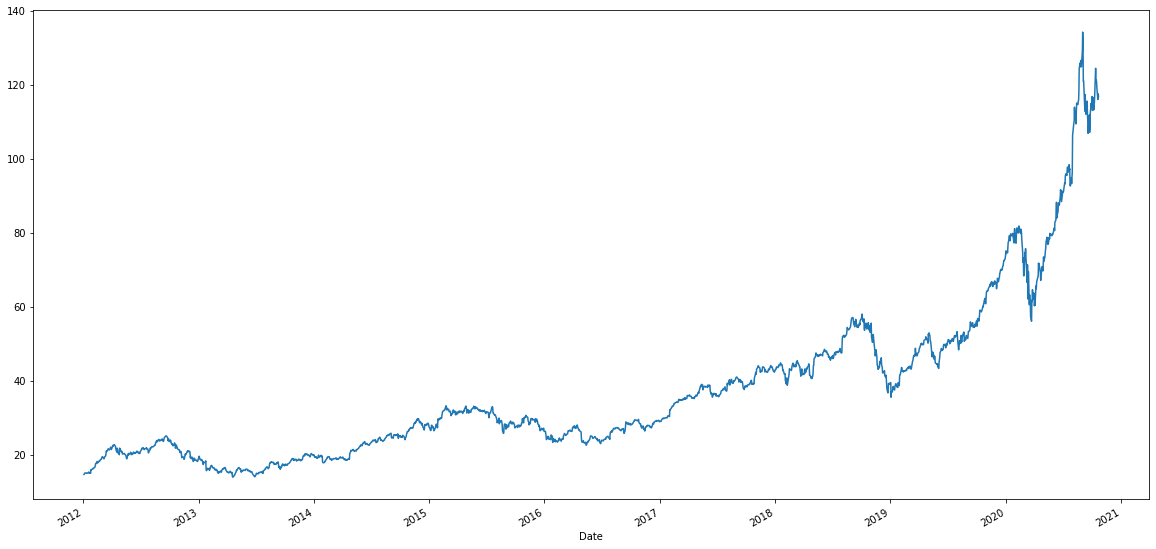

In [ ]:
df['Close'].plot(figsize=(20,10))

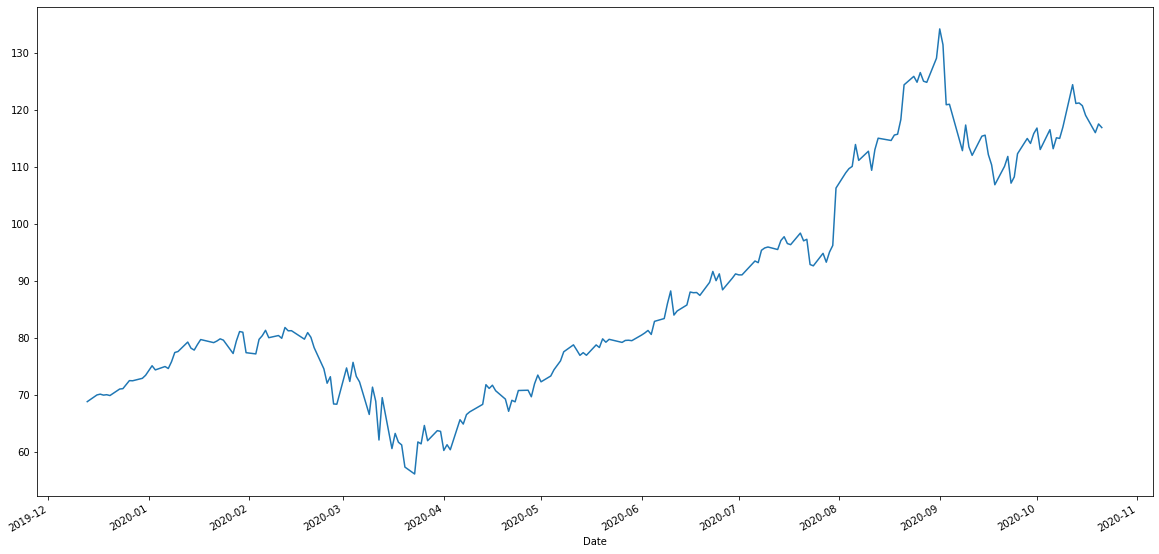

In [ ]:
# See the growth of our stock prices in last year only . 
df.iloc[2000:2300]['Close'].plot(figsize=(20,10))

In [ ]:
# Conver to Series to run Dickey-Fuller test
df = pd.Series(df['Close'])

In [ ]:
 # Check Stationarity by many methods like diff , log 
 def check_stationarity(ts_data):
    
    # Rolling statistics
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(5).std()
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

Dickey-Fuller test results

Test Statistic       2.537286
p-value              0.999061
# of lags           27.000000
# of obs          2188.000000
dtype: float64
Critical value at 1%: -3.43334
Critical value at 5%: -2.86286
Critical value at 10%: -2.56747


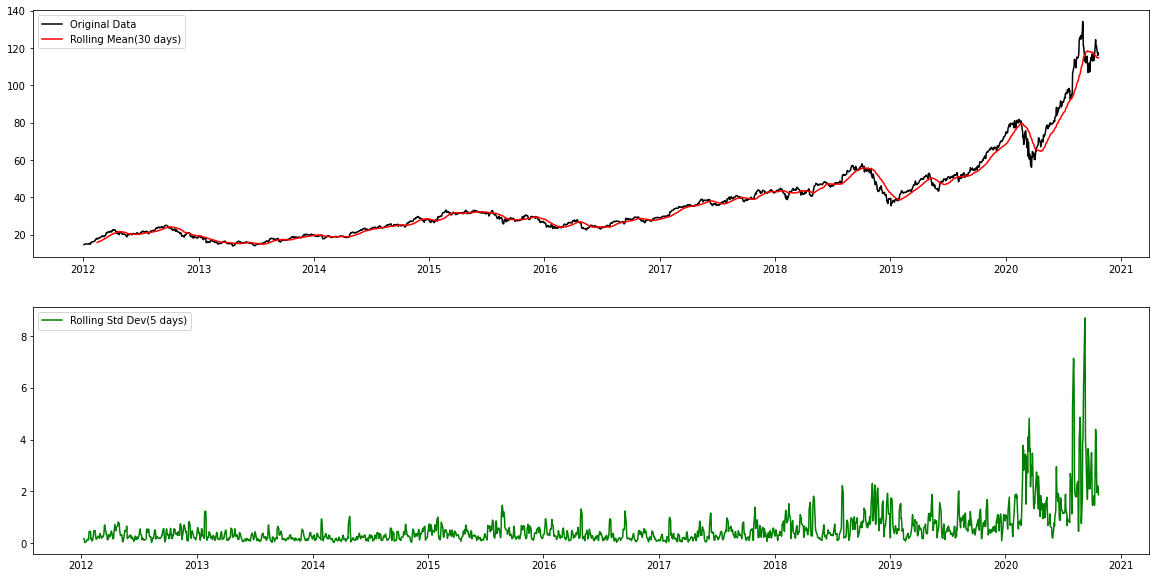

In [ ]:
check_stationarity(df)

In [ ]:

df_final_log = np.log(df)
df_final_log.head()

Date
2012-01-03    2.686948
2012-01-04    2.692308
2012-01-05    2.703349
2012-01-06    2.713748
2012-01-09    2.712161
Name: Close, dtype: float64

Dickey-Fuller test results

Test Statistic       0.436364
p-value              0.982805
# of lags           15.000000
# of obs          2200.000000
dtype: float64
Critical value at 1%: -3.43333
Critical value at 5%: -2.86285
Critical value at 10%: -2.56747


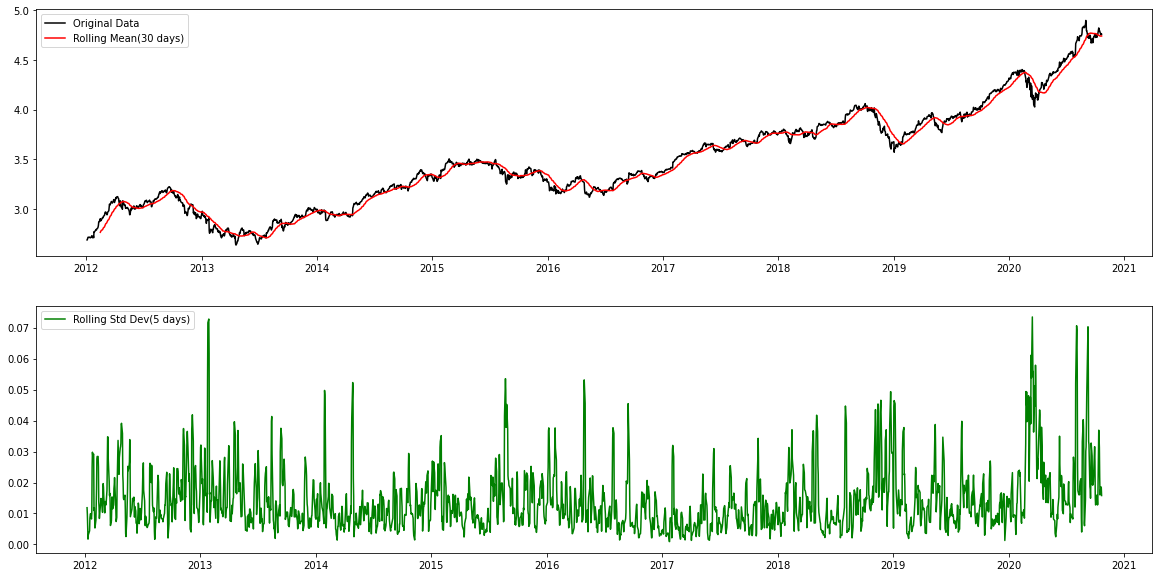

In [ ]:
# Check stationarity
df_final_log.dropna(inplace=True)
check_stationarity(df_final_log)

Here after take log on Close data , It still not stationary because p-value is >0.05 and test statistic is a positive .

In [ ]:
# Log Differencing
df_final_log_diff = df_final_log - df_final_log.shift()

Dickey-Fuller test results

Test Statistic   -1.152516e+01
p-value           3.952515e-21
# of lags         1.400000e+01
# of obs          2.200000e+03
dtype: float64
Critical value at 1%: -3.43333
Critical value at 5%: -2.86285
Critical value at 10%: -2.56747


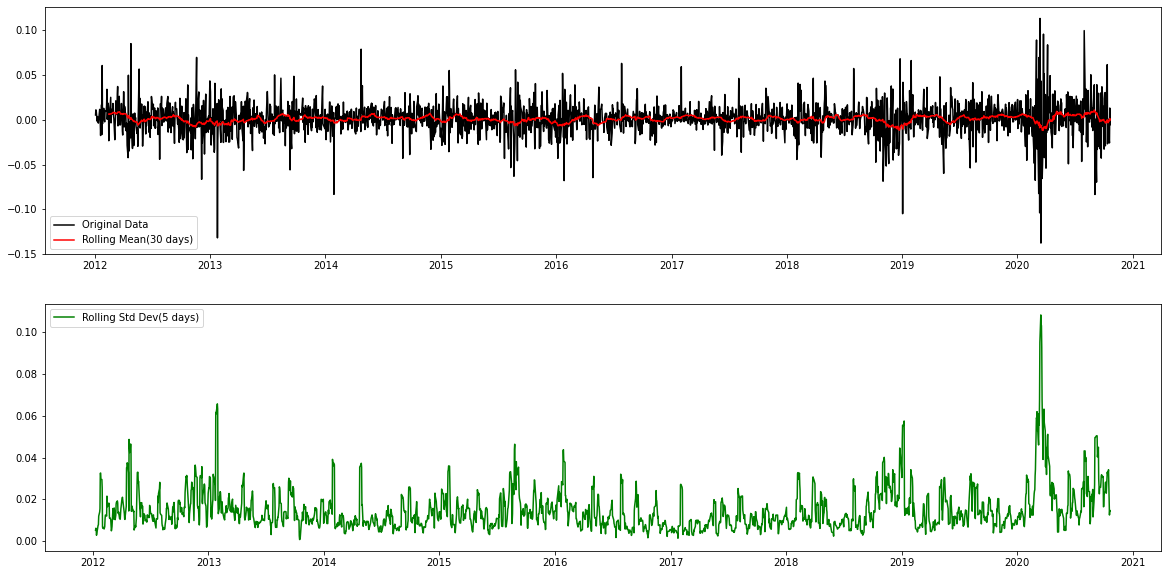

In [ ]:
df_final_log_diff.dropna(inplace=True)
check_stationarity(df_final_log_diff)

Here data is become stationary .

In [ ]:
df_final_diff = df - df.shift()

Dickey-Fuller test results

Test Statistic   -9.411508e+00
p-value           5.818469e-16
# of lags         2.600000e+01
# of obs          2.188000e+03
dtype: float64
Critical value at 1%: -3.43334
Critical value at 5%: -2.86286
Critical value at 10%: -2.56747


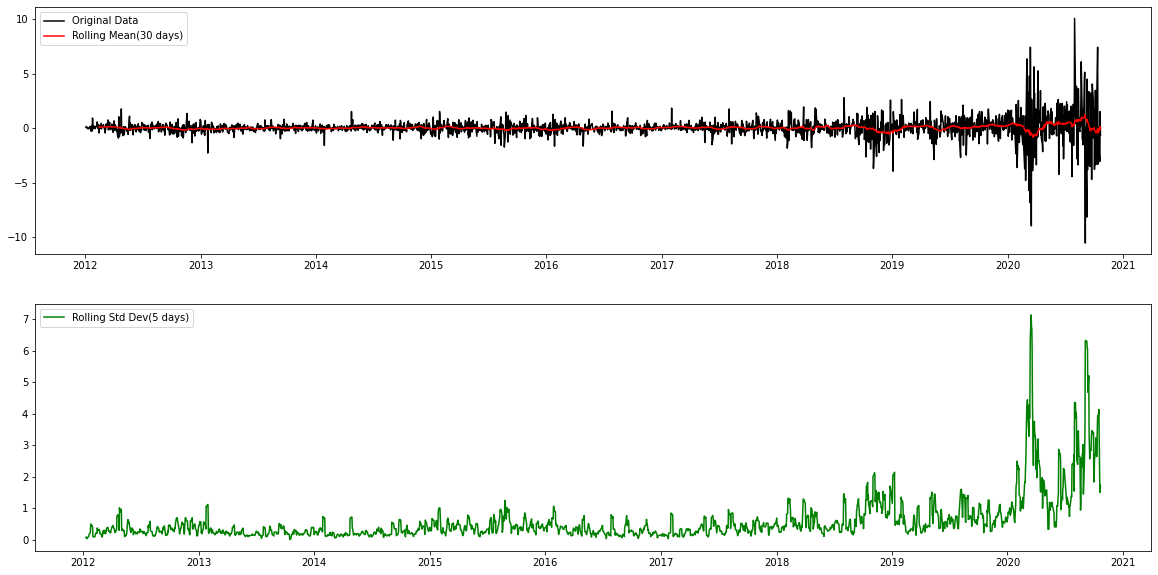

In [ ]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

Here I'm sure that our data become stationary after one difference where our p-value is a very small and test statistics become a big negative number.

In [ ]:
#Autocorrelation function
df_acf = acf(df_final_diff)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [ ]:
#Partial autocorrelation function
df_pacf = pacf(df_final_diff)

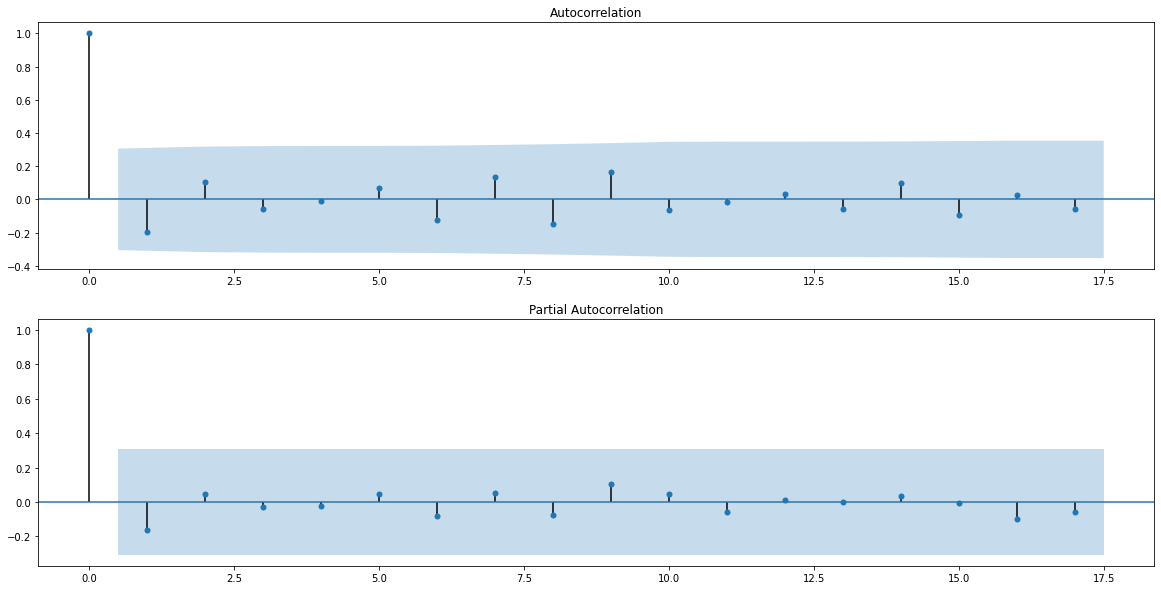

In [ ]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_acf, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_pacf, ax=ax2)

# Auto arima model

 we run some models and take the most least mean squared erro (MSE)

In [ ]:
 
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
 
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
 
 
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1256.944
ARIMA(0, 0, 1) MSE=327.941
ARIMA(0, 1, 0) MSE=2.362
ARIMA(0, 1, 1) MSE=2.341
ARIMA(0, 1, 2) MSE=2.364
ARIMA(0, 2, 0) MSE=5.408
ARIMA(0, 2, 1) MSE=2.373
ARIMA(1, 0, 0) MSE=2.369
ARIMA(1, 1, 0) MSE=2.340
ARIMA(1, 2, 0) MSE=3.568
ARIMA(2, 0, 0) MSE=292872328.704
ARIMA(2, 1, 0) MSE=2.363
ARIMA(2, 1, 1) MSE=2.356
ARIMA(2, 2, 0) MSE=3.183
ARIMA(2, 2, 1) MSE=2.390
Best ARIMA(1, 1, 0) MSE=2.340


In [ ]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
 
X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
error

predicted=39.058653, expected=39.275002
predicted=39.294858, expected=39.102501
predicted=39.116563, expected=39.352501
predicted=39.372539, expected=40.762501
predicted=40.801463, expected=41.680000
predicted=41.717199, expected=42.259998
predicted=42.291791, expected=41.722500
predicted=41.728867, expected=42.027500
predicted=42.052101, expected=43.125000
predicted=43.168422, expected=43.562500
predicted=43.592278, expected=43.702499
predicted=43.725159, expected=44.060001
predicted=44.088275, expected=43.970001
predicted=43.987177, expected=43.667500
predicted=43.679205, expected=43.492500
predicted=43.507167, expected=42.834999
predicted=42.836783, expected=42.270000
predicted=42.272737, expected=42.775002
predicted=42.806605, expected=42.537498
predicted=42.549819, expected=42.494999
predicted=42.512219, expected=43.285000
predicted=43.323720, expected=43.740002
predicted=43.771202, expected=43.742500
predicted=43.761626, expected=43.522499
predicted=43.535544, expected=43.267502


2.3397313198000913

In [ ]:
pred=pd.Series(predictions)

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mse =np.mean((forecast - actual)**2) # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
 
    return({'mape':mape, 'mse': mse, 
            'rmse':rmse})
 
forecast_accuracy(pred, test)

{'mape': array([1.45792627]),
 'mse': array([2.33973132]),
 'rmse': array([1.52961803])}

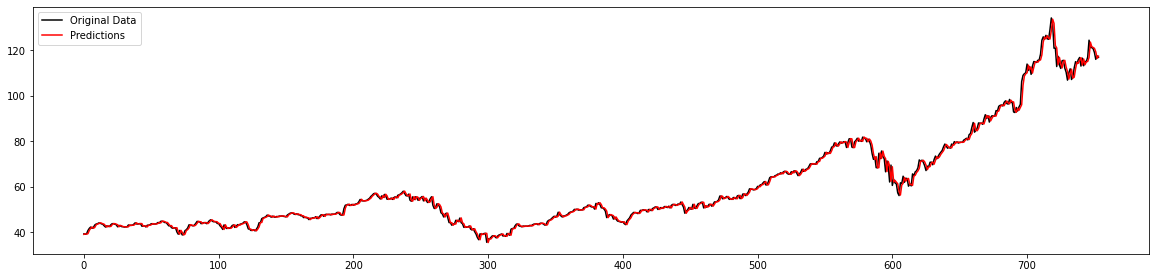

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(test, color='black', label='Original Data')
plt.plot(predictions, color='red', label='Predictions')
plt.legend()